# The `unmarked` R package for fitting hierarchical models of animal abundance and occurrence

Ken Kellner

# Outline

1. Overview of hierarchical models
2. The `unmarked` package
    - Organization
    - Supported models
3. Package demonstration
4. Recent features
    - Random effects
    - Simulation
    - Power analysis
5. Future directions
6. Questions

# Overview of hierarchical models in ecology

* Detection is imperfect when observing animal populations
* If detection is ignored, we're actually measuring a combination of state and detection processes
* Solution: explicitly model state and detection processes separately

## Classic example: the occupancy model

![](images/occupancy.png)

### State process

**Parameters**

$z_i$: Latent occupancy at site $i$

$\psi_i$: Occupancy probability at site $i$

**Math**

$$z_i \sim \mathrm{Bernoulli}(\psi_i)$$

Model $\psi$ as function of covariates:

$$\psi_i = \mathrm{logit}^{-1}(\beta_0 + \beta_x \cdot x_i ... )$$

### Detection process

**Parameters/data**

$y_{ij}$: Observed detection at site $i$ for repeated sample $j$

$p_{ij}$: Probability of detecting an individual at site $i$ in sample $j$

**Math**

$$y_{ij} \sim \mathrm{Bernoulli}(p_{ij} \cdot z_i)$$

### Data example

| Site | Occasion 1 | Occasion 2 | Occasion 3|
|------|------------|------------|-----------|
| A    | 0          | 1          | 0         |
| B    | 1          | 0          | 1         |
| C    | 0          | 0          | 0         |

### Key assumptions

* Population is closed during the repeated samples
* Repeated samples are independent
* No unmodeled heterogeneity
* No false positive detections (only false negative)

## Extension to counts

$$N_i \sim \mathrm{Poisson}(\lambda_i)$$

$$y_{ij} \sim \mathrm{Binomial}(p_{ij}, N_i)$$

### Data example

| Site | Occasion 1 | Occasion 2 | Occasion 3|
|------|------------|------------|-----------|
| A    | 3          | 1          | 0         |
| B    | 5          | 7          | 4         |
| C    | 0          | 0          | 0         |

# The `unmarked` package

* Specifically focused on models for *unmarked* animals
* Other software exists for *marked* animals, such as `MARK`
* Around since ~2009
* Original developers were Ian Fiske and Richard Chandler (but many others have contributed)

## Package organization
![](images/organization.png)

## Metric
![](images/metrics.png)

## Temporal design
![](images/temporal_design.png)

## Observed data types
![](images/data_types.png)

## Occupancy model types

| Data type              | One period    | Multiple secondary | Multiple primary |
|------------------------|---------------|--------------------|------------------|
| Detection/nondetection | `occu()`      | `goccu()`          | `colext()`       |
|  + multiple species    | `occuComm()`  |                    |                  |
|  + species interactions| `occuMulti()` |                    |                  |
|  + false positives     | `occuFP()`    |                    |                  |
|  + >2 possible states  | `occuMS()`    |                    | `occuMS()`       |
|                        |               |                    |                  |
| Time-to-detection      | `occuTTD()`   |                    | `occuTTD()`      |
| Counts                 | `occuCOP()`   |                    |                  |

## Abundance model types

| Data type              | One period      | Multiple secondary | Multiple primary |
|------------------------|-----------------|--------------------|------------------|
| Detection/nondetection | `occuRN()`      |                    |                  |
| Repeated counts        | `pcount()`      | `gpcount()`        | `pcountOpen()`   |
| Distance sampling      | `distsamp()`    | `gdistsamp()`      | `distsampOpen()` |
| Double observer/removal| `multinomPois()`| `gmultmix()`       | `multmixOpen()`  |
| Distance + removal     | `gdistremoval()`| `gdistremoval()`   |                  |
| Time-to-detection      | `nmixTTD()`     |                    |                  |

# Package demonstration

1. Format data
2. Fit model
3. Goodness-of-fit
4. Prediction

In [1]:
library(unmarked)

## 1. Format data


* Detection/non-detection of common crossbill in Switzerland
* Modified from `crossbill` dataset built into `unmarked` (see `?crossbill`)

![](images/crossbill.jpg)

### Detection/non-detection data

In [2]:
# Set working directory to the Github repo folder
# setwd()
y <- read.csv("data/y.csv")
dim(y)
head(y)

[1] 801   3

,occ1,occ2,occ3
,<int>,<int>,<int>
1,0,0,0
2,0,0,0
3,NA,NA,NA
4,0,0,0
5,0,0,0
6,NA,NA,NA


### Site-level covariates

In [3]:
site_covs <- read.csv("data/site_covs.csv")
dim(site_covs)
head(site_covs)

[1] 801   3

,id,forest,ele
,<int>,<int>,<int>
1,1,3,450
2,2,21,450
3,3,32,1050
4,4,9,950
5,5,35,1150
6,6,2,550


### Observation-level covariate

In [4]:
date <- read.csv("data/dates.csv")
dim(date)
head(date)

[1] 801   3

,date1,date2,date3
,<int>,<int>,<int>
1,34,59,65
2,17,33,65
3,NA,NA,NA
4,29,59,65
5,24,45,65
6,NA,NA,NA


### Create `unmarkedFrame`

Organizes all the data into a single, `data.frame`-like object

In [5]:
umf <- unmarkedFrameOccu(y = y,
                         siteCovs = site_covs,
                         obsCovs = list(date = date))

head(umf)

Data frame representation of unmarkedFrame object.
  y.1 y.2 y.3 id forest  ele date.1 date.2 date.3
1   0   0   0  1      3  450     34     59     65
2   0   0   0  2     21  450     17     33     65
3  NA  NA  NA  3     32 1050     NA     NA     NA
4   0   0   0  4      9  950     29     59     65
5   0   0   0  5     35 1150     24     45     65
6  NA  NA  NA  6      2  550     NA     NA     NA

## 2. Fit occupancy model with `occu` function

Models are specified with R formulas (`~1`)

In [6]:
mod_null <- occu(~1 ~1, data = umf)
summary(mod_null)

Warning message:
“Site(s) 3,6,38,63,71,106,116,118,125,126,152,163,168,178,181,197,199,212,218,220,238,257,282,303,541,548,568,570,577,721,736 dropped due to missing values”



Call:
occu(formula = ~1 ~ 1, data = umf)

Occupancy (logit-scale):
 Estimate     SE     z  P(>|z|)
   -0.807 0.0881 -9.16 5.26e-20

Detection (logit-scale):
 Estimate     SE    z P(>|z|)
    0.216 0.0971 2.22  0.0261

AIC: 1701.908 
Number of sites: 770
ID of sites removed due to NA: 3 6 38 63 71 106 116 118 125 126 152 163 168 178 181 197 199 212 218 220 238 257 282 303 541 548 568 570 577 721 736



In [32]:
plogis(-0.807)
plogis(0.216)

[1] 0.3085301

[1] 0.553791

### Covariate model

Model detection as a function of date: `~date`

Model occupancy as a function of forest and elevation: `~forest + ele`

Full formula: `~1 ~forest + ele`

In [7]:
# Scale all covariates
mod_covs <- occu(~scale(date) ~scale(forest) + scale(ele), data = umf)
summary(mod_covs)

Warning message:
“Site(s) 3,6,38,63,71,106,116,118,125,126,152,163,168,178,181,197,199,212,218,220,238,257,282,303,541,548,568,570,577,721,736 dropped due to missing values”



Call:
occu(formula = ~scale(date) ~ scale(forest) + scale(ele), data = umf)

Occupancy (logit-scale):
              Estimate    SE     z  P(>|z|)
(Intercept)     -1.066 0.108 -9.85 6.78e-23
scale(forest)    0.984 0.108  9.08 1.10e-19
scale(ele)       0.801 0.111  7.22 5.14e-13

Detection (logit-scale):
            Estimate     SE    z P(>|z|)
(Intercept)    0.179 0.0981 1.82 0.06839
scale(date)    0.316 0.0921 3.44 0.00059

AIC: 1547.462 
Number of sites: 770
ID of sites removed due to NA: 3 6 38 63 71 106 116 118 125 126 152 163 168 178 181 197 199 212 218 220 238 257 282 303 541 548 568 570 577 721 736



## 3. Goodness-of-fit

`unmarked` has a built-in parametric bootstrap tool:

1. Apply fit statistic based on actual model fit
2. Simulate new "perfect" datasets based on model
3. Fit models to "perfect" datasets and apply fit statistic
4. Compare real to bootstrapped statistic values

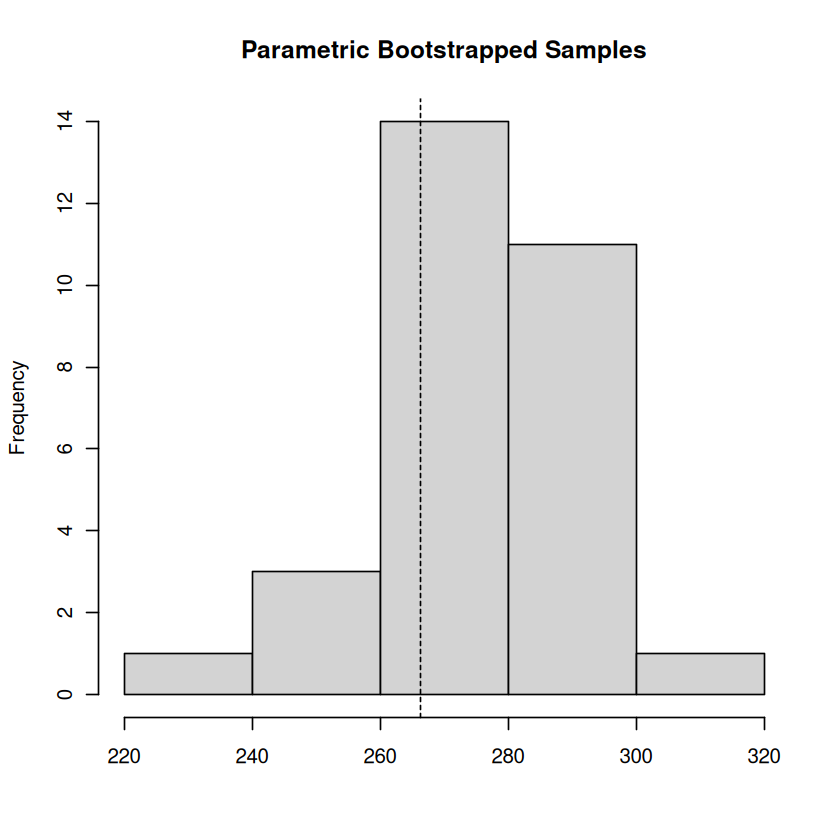

In [8]:
set.seed(1)
# Default statistic is sum of squared residuals
pb <- suppressWarnings(parboot(mod_covs, nsim = 30))
plot(pb)

Alternatively, consider the specialized MacKenzie-Bailey chi-square statistic provided by `AICcmodavg`:

```r
AICcmodavg::mb.gof.test
```

## 4. Prediction

For all sites:

In [9]:
pr <- predict(mod_covs, type = "state")
head(pr)

Warning message:
“Site(s) 3,6,38,63,71,106,116,118,125,126,152,163,168,178,181,197,199,212,218,220,238,257,282,303,541,548,568,570,577,721,736 dropped due to missing values”


,Predicted,SE,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.04222031,0.01085721,0.02538335,0.06942977
2,0.07722407,0.01567777,0.05156942,0.11410588
3,0.09258645,0.01588934,0.06579591,0.12878171
4,0.24856602,0.02060417,0.21040561,0.29109590
5,0.06663739,0.01373915,0.04425683,0.09916150
6,0.30121467,0.03247153,0.24160779,0.36838398


For a site with arbitrary covariate values, use `newdata`:

In [10]:
nd <- data.frame(ele = 500, forest = 10)
predict(mod_covs, type = "state", newdata = nd)

Predicted,SE,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.05679344,0.01293538,0.03615382,0.08813839


To instantly generate an effects plot for a covariate:

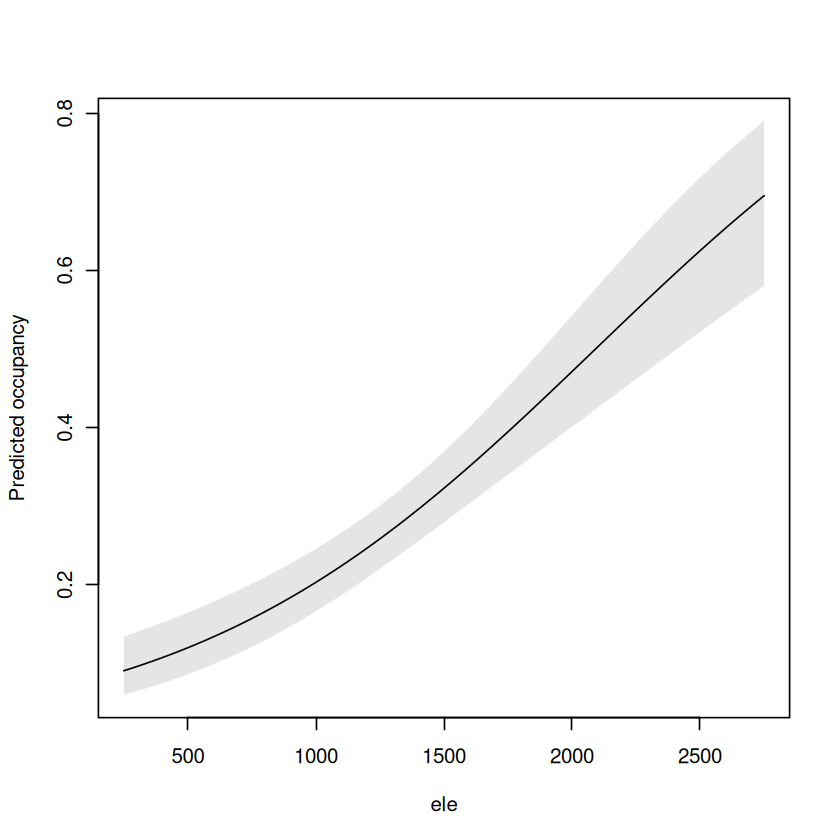

In [11]:
plotEffects(mod_covs, type = "state", covariate = "ele")

To create a map:

terra 1.8.60



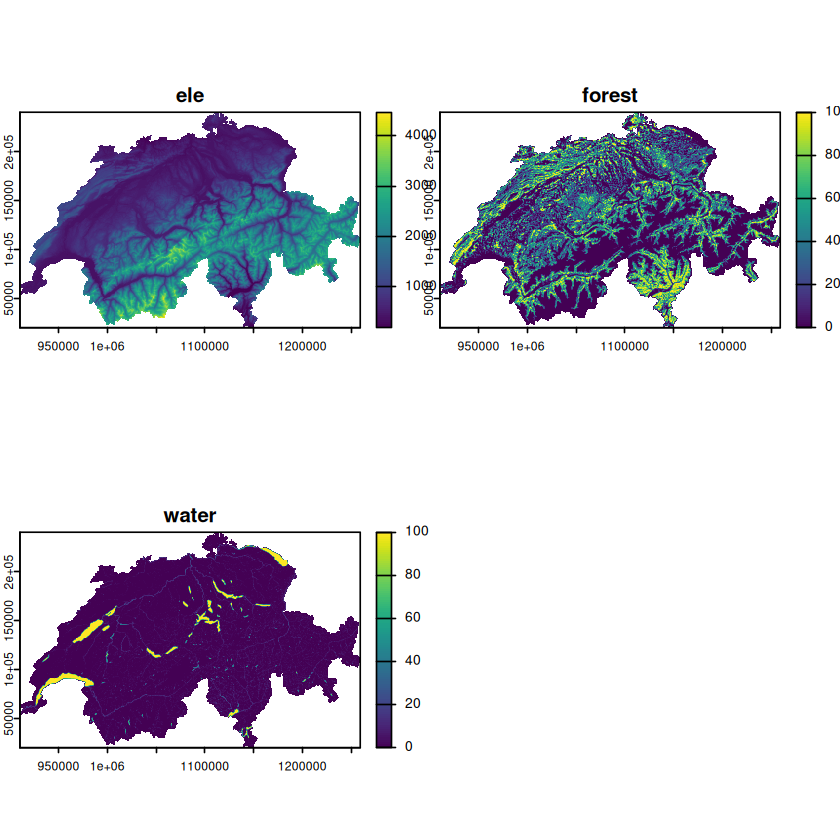

In [12]:
library(terra)
data(Switzerland) # provided with unmarked

switz_rast <- rast(Switzerland)
names(switz_rast) <- c("ele", "forest", "water")
plot(switz_rast)

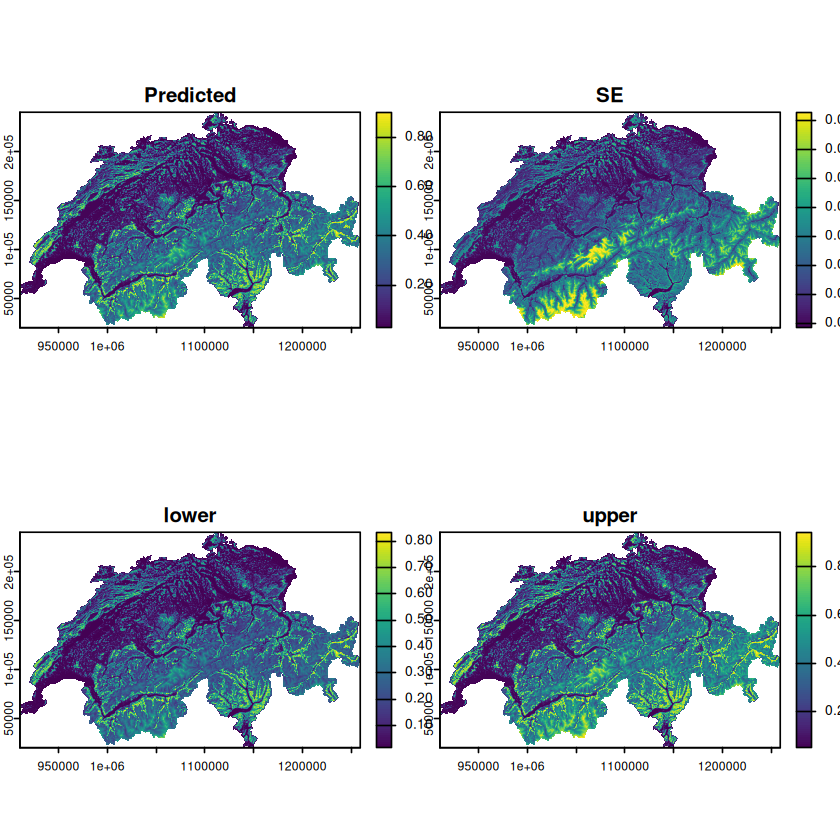

In [13]:
pr_rast <- predict(mod_covs, type = "state", newdata = switz_rast)
plot(pr_rast)

# Recent Features

## Random effects

* `crossbill` data has repeated observations of the same sites (`id`)
* We could include a random site effect to account for this pseudoreplication

$$\beta_{0, i} \sim \mathrm{Normal}(\beta_{0, mean}, \sigma)$$

In [14]:
head(umf)

Data frame representation of unmarkedFrame object.
  y.1 y.2 y.3 id forest  ele date.1 date.2 date.3
1   0   0   0  1      3  450     34     59     65
2   0   0   0  2     21  450     17     33     65
3  NA  NA  NA  3     32 1050     NA     NA     NA
4   0   0   0  4      9  950     29     59     65
5   0   0   0  5     35 1150     24     45     65
6  NA  NA  NA  6      2  550     NA     NA     NA

In [15]:
# Random grouping must be R factor
site_covs$id <- factor(site_covs$id)
siteCovs(umf) <- site_covs

Random effects are specified in the formula(s) using `lme4`-type syntax

For example, a random intercept by `id` would be `~(1 | id)`

In [16]:
mod_rand <- occu(~scale(date) ~scale(forest) + scale(ele) + (1|id), data = umf)
summary(mod_rand)

Warning message:
“Site(s) 3,6,38,63,71,106,116,118,125,126,152,163,168,178,181,197,199,212,218,220,238,257,282,303,541,548,568,570,577,721,736 dropped due to missing values”



Call:
occu(formula = ~scale(date) ~ scale(forest) + scale(ele) + (1 | 
    id), data = umf)

Occupancy (logit-scale):
Random effects:
 Groups        Name Variance Std.Dev.
     id (Intercept)    2.286    1.512

Fixed effects:
              Estimate    SE     z  P(>|z|)
(Intercept)      -1.51 0.197 -7.67 1.76e-14
scale(forest)     1.34 0.193  6.96 3.30e-12
scale(ele)        1.04 0.183  5.70 1.23e-08

Detection (logit-scale):
            Estimate     SE    z  P(>|z|)
(Intercept)    0.225 0.0956 2.35 0.018619
scale(date)    0.331 0.0908 3.65 0.000262

AIC: 1519.104 
Number of sites: 770
ID of sites removed due to NA: 3 6 38 63 71 106 116 118 125 126 152 163 168 178 181 197 199 212 218 220 238 257 282 303 541 548 568 570 577 721 736



Get the actual values of the random `id` intercepts:

In [17]:
head(randomTerms(mod_rand))

,Model,Groups,Name,Level,Estimate,SE,lower,upper
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,psi,id,(Intercept),1,-0.07998082,1.4559675,-2.9336247,2.773663
2,psi,id,(Intercept),2,-0.16661696,1.4037812,-2.9179776,2.584744
3,psi,id,(Intercept),3,1.00149911,1.1298760,-1.2130171,3.216015
4,psi,id,(Intercept),4,1.36970218,1.1962765,-0.9749567,3.714361
5,psi,id,(Intercept),5,1.48788887,0.9950673,-0.4624072,3.438185
6,psi,id,(Intercept),6,-0.06039060,1.4691381,-2.9398483,2.819067


## Simulation

Simulated datasets are useful for many purposes:

* Creating teaching examples
* Exploring experimental designs
* Testing parameter identifiability
* Bootstrapping
* Goodness-of-fit tests
* Power analyses

`unmarked` includes tools for simulating nearly any type of supported dataset from scratch.

### Define the experimental design

In [18]:
set.seed(1)
sites <- 100
reps <- 3
yblank <- matrix(NA, sites, reps) # blank y-matrix

### Create covariate(s)

In [19]:
sim_covs <- data.frame(forest = rnorm(sites))

### Build `unmarkedFrame`

Note that the actual observed data are still blank

In [20]:
umf_blank <- unmarkedFrameOccu(y = yblank, siteCovs = sim_covs)
head(umf_blank)

Data frame representation of unmarkedFrame object.
  y.1 y.2 y.3     forest
1  NA  NA  NA -0.8356286
2  NA  NA  NA  1.5952808
3  NA  NA  NA  0.3295078
4  NA  NA  NA -0.8204684
5  NA  NA  NA  0.4874291
6  NA  NA  NA  0.7383247

### Specify the parameter values / coefficients

* On the link scale
* Provided in a list for each submodel

In [21]:
coefs <- list(state = c(-1.5, 1), # occupancy intercept = -1.5, forest effect = 1 
              det = 0.2)          # detection intercept = 0.2

In [22]:
plogis(-1.5)
plogis(0.2)

[1] 0.1824255

[1] 0.549834

### Run the `simulate` function

Required info:

1. The blank experimental design (i.e., the `unmarkedFrame`)
2. The name of the model we want to simulate from
3. The model structure as a formula
4. The coefficient/parameter values
5. The number of simulated datasets to create

In [23]:
s <- simulate(umf_blank, 
              model = occu, 
              formula = ~1 ~forest, 
              coefs = coefs, 
              nsim = 3)

head(s[[1]])

Assumed parameter order for state:
(Intercept), forest

Assumed parameter order for det:
(Intercept)



Data frame representation of unmarkedFrame object.
  y.1 y.2 y.3     forest
1   0   0   0 -0.8356286
2   0   0   0  1.5952808
3   0   0   0  0.3295078
4   0   0   0 -0.8204684
5   1   0   1  0.4874291
6   0   0   0  0.7383247

Fit a model to one of the simulated datasets as a check:

In [24]:
occu(~1~forest, data = s[[1]])


Call:
occu(formula = ~1 ~ forest, data = s[[1]])

Occupancy (logit-scale):
            Estimate    SE     z  P(>|z|)
(Intercept)   -1.375 0.308 -4.46 8.29e-06
forest         0.816 0.327  2.49 1.26e-02

Detection (logit-scale):
 Estimate    SE      z P(>|z|)
     0.01 0.309 0.0324   0.974

AIC: 183.3249 
Number of sites: 100


## Power analysis

**Type I error (ɑ)**: The probability we reject a null hypothesis when it is true

**Type II error (β)**: The probability we fail to reject a null hypothesis when it is false

**Power (1 – β)**: The probability we reject a null hypothesis when it is false

### What affects power?

* Bigger sample size = more power
* Bigger (absolute) effect size = more power
* Choice of ɑ

### Hierarchical models and power

* Significance testing commonly used for hierarchical models in ecology
* Power rarely reported
* HMs require larger sample sizes than equivalent regressions (more complex, more parameters)
* No closed form power equations for HMs usually

### `powerAnalysis` function

Uses simulation-based approach

Required arguments:

1. Experimental design (as `unmarkedFrame`)
2. Model type
3. Formula describing model covariates
4. Effect sizes to test
5. Number of simulations

In [25]:
numSites(umf_blank)

[1] 100

In [26]:
set.seed(5)
pa100 <- powerAnalysis(umf_blank, 
                       model = occu, 
                       formula = ~1 ~ forest, 
                       effects = coefs,
                       nsim = 100)
pa100

Assumed parameter order for state:
(Intercept), forest

Assumed parameter order for det:
(Intercept)



Model: occu
Sites: 100
Primary Periods: 1
Occasions: 3
alpha: 0.05

Power Statistics:
 Submodel Parameter Effect Power Type S Type M
    state    forest      1  0.88      0  1.164

We have power ~0.9 to detect an effect size of 1 under this design.

#### Comparing various designs

E.g., by varying the number of sites

In [27]:
pa50 <- powerAnalysis(umf_blank[1:50,], model = occu, formula = ~1 ~ forest, effects = coefs,
                      nsim = 100)
pa25 <- powerAnalysis(umf_blank[1:25,], model = occu, formula = ~1 ~ forest, effects = coefs,
                      nsim = 100)

Assumed parameter order for state:
(Intercept), forest

Assumed parameter order for det:
(Intercept)

Assumed parameter order for state:
(Intercept), forest

Assumed parameter order for det:
(Intercept)

Warning message in sqrt(diag(vcov(obj, fixedOnly = fixedOnly))):
“NaNs produced”


#### Look at power for the 50-site design

In [28]:
pa50

Model: occu
Sites: 50
Primary Periods: 1
Occasions: 3
alpha: 0.05

Power Statistics:
 Submodel Parameter Effect Power Type S Type M
    state    forest      1  0.41      0  1.814

* Much lower power
* Type S error: probability of getting a significant effect with the wrong **S**ign
* Type M error: measure of effect size **M**agnitude relative to truth

#### Type M error

Usually high (i.e., we overestimate the absolute effect size) when power is low

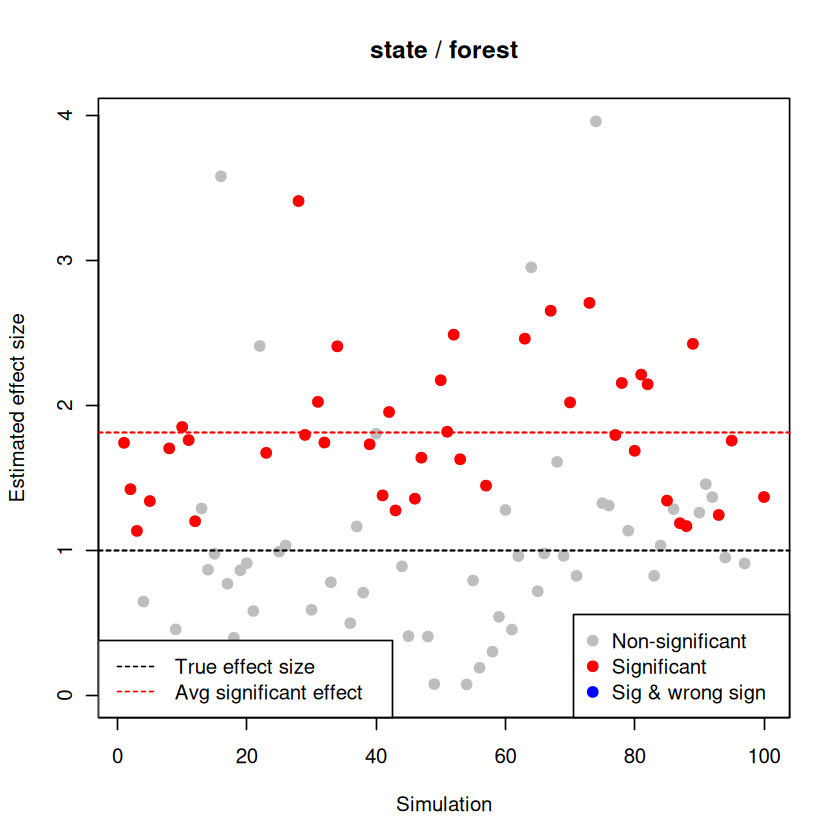

In [29]:
plot(pa50)

If you have low power but find a significant effect, you might be tempted to think all is well, but it may not be!

#### Visually compare power for different sample sizes

Organize the objects into an `unmarkedPowerList`

In [30]:
pa_list <- unmarkedPowerList(pa25, pa50, pa100)
pa_list

Model: occu 
Number of sites (M):           25, 50, 100 
Number of primary periods (T): 1, 1, 1 
Number of occasions (J):       3, 3, 3 
alpha:                         0.05 

    M T J Submodel Parameter Effect Null      Power Type S   Type M
1  25 1 3    state    forest      1    0 0.01010101      0 3.939396
2  50 1 3    state    forest      1    0 0.41000000      0 1.814293
3 100 1 3    state    forest      1    0 0.88000000      0 1.163927

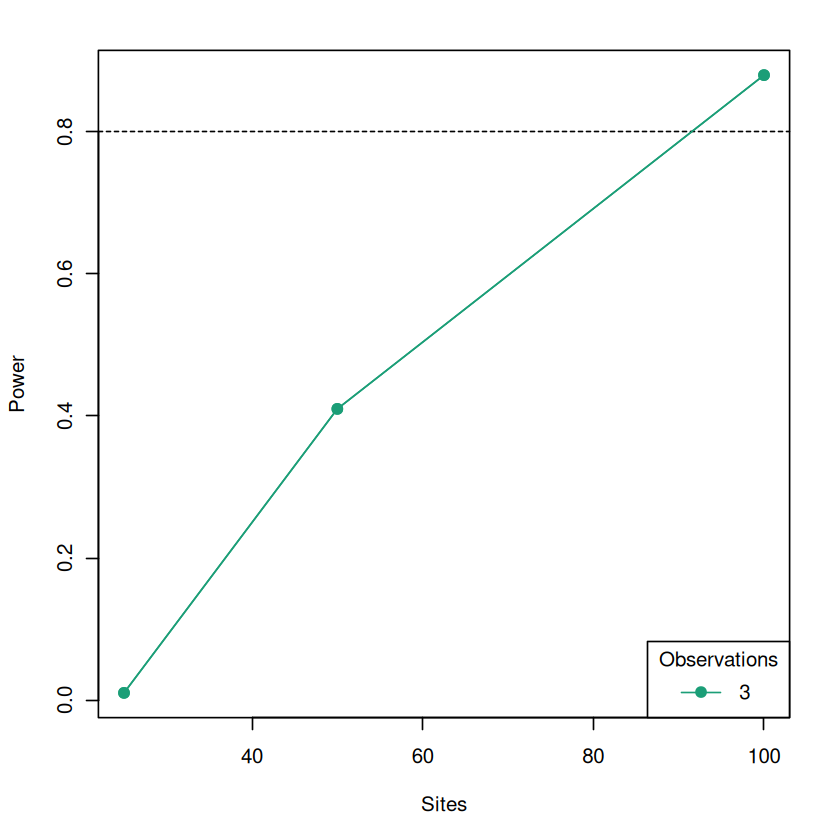

In [31]:
plot(pa_list, power = 0.8)

# Future directions

* Ingest outputs from AI tools (Wildlife Insights, ARUs, etc.)
* Collaboration / interoptability with other R packages (`spOccupancy`, `spAbundance`, `nimble`)
* Expand random effects support
* Continuous-time detection models
* **Long term maintenance**

# Questions?

https://cran.r-project.org/package=unmarked (many vignettes)

https://github.com/ecoverseR/unmarked

Previous ESA/EFI seminar on [multispecies occupancy models in unmarked](https://htmlpreview.github.io/?https://github.com/eco4cast/Statistical-Methods-Seminar-Series/blob/main/Rota-MSOM/MSOM-Presentation.html)

kellner7@msu.edu